In [25]:
%load_ext autoreload
%autoreload 2
%matplotlib qt

import sys; sys.path.insert(0, '../') 
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from scipy.spatial.distance import cdist
import mne

from invert.forward import get_info, create_forward_model
from invert.util import pos_from_forward
from invert.evaluate import eval_auc, eval_mean_localization_error, eval_mean_localization_error_old

pp = dict(surface='inflated', hemi='both', verbose=0, cortex='low_contrast')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
sampling = "ico3"
info = get_info(kind='biosemi64')
fwd = create_forward_model(info=info, sampling=sampling)
fwd["sol"]["data"] /= np.linalg.norm(fwd["sol"]["data"], axis=0) 
pos = pos_from_forward(fwd)
leadfield = fwd["sol"]["data"]
n_chans, n_dipoles = leadfield.shape

source_model = fwd['src']
vertices = [source_model[0]['vertno'], source_model[1]['vertno']]
adjacency = mne.spatial_src_adjacency(fwd["src"], verbose=0)
distance_matrix = cdist(pos, pos)
fwd

Good channels,64 EEG
Bad channels,None
Source space,Surface with 1284 vertices
Source orientation,Fixed


# Simulate

In [27]:
from invert.simulate import generator
sim_params = dict(
    use_cov=False,
    return_mask=False,
    batch_repetitions=1,
    batch_size=1,
    n_sources=3,
    n_orders=(1, 1),
    snr_range=(20, 25),
    amplitude_range=(1, 1),
    n_timecourses=200,
    n_timepoints=50,
    scale_data=False,
    add_forward_error=False,
    forward_error=0.5,
    inter_source_correlation=0.25,
    return_info=True,
    diffusion_parameter=0.1,
    correlation_mode=None,
    noise_color_coeff=0,
    random_seed=None)

gen = generator(fwd, **sim_params)

No projector specified for this dataset. Please consider the method self.add_proj.
No projector specified for this dataset. Please consider the method self.add_proj.
No projector specified for this dataset. Please consider the method self.add_proj.


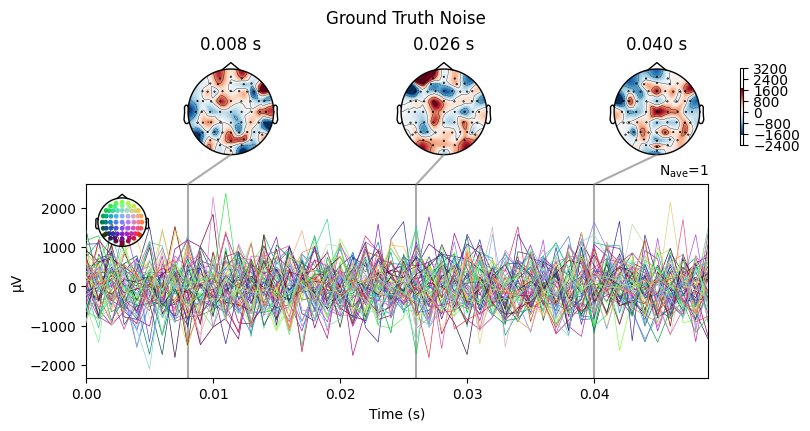

In [28]:
x, y, sim_info = gen.__next__()

tmin = 0
tstep = 1/info["sfreq"]
subject = "fsaverage"
evoked = mne.EvokedArray(x[0].T, info, tmin=tmin)
stc = mne.SourceEstimate(y[0].T, vertices, tmin=tmin, tstep=tstep, 
                        subject=subject, verbose=0)

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, "Ground Truth", 'title',
               font_size=14)
evoked.plot_joint(title="Ground Truth")

evoked_clean = mne.EvokedArray(leadfield @ y[0].T, info, tmin=tmin)
evoked_clean.plot_joint(title="Ground Truth Noiseless")

evoked_noise = evoked.copy()
evoked_noise.data -= evoked_clean.data
evoked_noise.plot_joint(title="Ground Truth Noise")

# Solve

## CovCNN

In [20]:
from invert.solvers.esinet import SolverCovCNN
from copy import deepcopy

train_params = deepcopy(sim_params)
train_params["batch_repetitions"] = 1
train_params["batch_size"] = 1284
train_params["n_filters"] = 256
train_params["epochs"] = 1000
train_params["n_orders"] = (0, 2)
train_params["snr_range"] = [1, 10]
train_params["n_sources"] = (1, 5)
train_params["output_activation"] = "sigmoid"

solver = SolverCovCNN()
solver.make_inverse_operator(fwd, evoked, **train_params)

Create Generator:..
Build Model:..
Train Model:..
Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: -0.1791 - val_loss: -0.1824
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: -0.1834 - val_loss: -0.1889
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: -0.1886 - val_loss: -0.1968
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: -0.1972 - val_loss: -0.2033
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: -0.2047 - val_loss: -0.2095
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: -0.2092 - val_loss: -0.2149
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: -0.2128 - val_loss: -0.2197
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: -0.2192 - val_loss: -0.2238
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: -0.2217 - val_loss: -0.2275
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: -0.2300 - val_loss: -0.2310
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: -0.2296 - val_loss: -0.2341
Epoch 12/

In [24]:
stc_ = solver.apply_inverse_operator(evoked)
evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)

stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

stc_.data = solver.gammas[:, np.newaxis]
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, "Gamma", 'title',
               font_size=14)

evoked_.plot_joint()

# print(solver.name, " r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])

mle = eval_mean_localization_error(stc.data, stc_.data, adjacency.toarray(), adjacency.toarray(), distance_matrix)
print(solver.name, "mle = ", mle, " mm")

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Cov-CNN mle =  32.63907112114764  mm


Using control points [0.00017998 0.0004553  0.01012863]
Using control points [0.07122347 0.09302622 0.3196906 ]


## SSM

In [29]:
from invert.solvers.music import SolverGeneralizedIterative
from invert import Solver
# solver = SolverGeneralizedIterative()

# solver.make_inverse_operator(fwd, evoked, 
#                              inverse_type="SSM", n_orders=1, 
#                              refine_solution=True, n=sim_params["n_sources"], 
#                              d=sim_params["n_sources"], diffusion_parameter="auto")

solver = Solver("GBF")
solver.make_inverse_operator(fwd, evoked, n_orders=sim_params["n_orders"][0], refine_solution=True, n=sim_params["n_sources"], 
                             k=sim_params["n_sources"], diffusion_parameter=0.1, stop_crit=0)

stc_ = solver.apply_inverse_operator(evoked)
stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
evoked_.plot_joint()

# print(solver.name, " r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])

mle = eval_mean_localization_error(stc.data, stc_.data, adjacency.toarray(), adjacency.toarray(), distance_matrix, mode="match")
print(solver.name, "mle = ", mle, " mm")

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Minimum Norm Estimate with Basis Functions mle =  10.492118656947488  mm


Using control points [0.        0.        0.0182335]
Using control points [0.19945064 0.26218802 0.70205245]
Using control points [0.19945064 0.26218802 0.70205245]
Using control points [0.16539258 0.19331322 0.62681542]
Using control points [0.16539258 0.19331322 0.62681542]


## LCMV

In [ ]:
from invert.solvers.music import SolverGeneralizedIterative
from invert import Solver
# solver = SolverGeneralizedIterative()
solver = Solver("mvab")
solver.make_inverse_operator(fwd, evoked)

stc_ = solver.apply_inverse_operator(evoked)
stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
evoked_.plot_joint()

# print(solver.name, " r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])

mle = eval_mean_localization_error(stc.data, stc_.data, adjacency.toarray(), adjacency.toarray(), distance_matrix)
print(solver.name, "mle = ", mle, " mm")

## FC

In [5]:
from invert import Solver
from copy import deepcopy

solver = Solver("FC")
# solver.make_inverse_operator(fwd, evoked, n_sources=2, n_orders=(0,1),snr_range=(0.2,0.2))
sim_params_train = deepcopy(sim_params)
sim_params_train["batch_repetitions"] = 5
sim_params_train["batch_size"] = 1284
sim_params_train["epochs"] = 1
solver.make_inverse_operator(fwd, evoked, **sim_params_train)
stc_ = solver.apply_inverse_operator(evoked)
stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
evoked_.plot_joint()

# print(solver.name, " r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])

mle = eval_mean_localization_error(stc.data, stc_.data, adjacency.toarray(), adjacency.toarray(), distance_matrix)
print(solver.name, "mle = ", mle, " mm")

Create Generator:..
Build Model:..
Train Model:..
5/5 [==============================] - 15s 3s/step - loss: -0.0373 - val_loss: -0.0873
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


c:\Users\lukas\virtualenvs\invertenv\lib\site-packages\scipy\optimize\_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Fully-Connected mle =  36.61812096852959  mm


In [6]:
solver.save("../models")

INFO:tensorflow:Assets written to: ../models\Fully-Connected_0\assets


INFO:tensorflow:Assets written to: ../models\Fully-Connected_0\assets


## FLAP

In [ ]:
from invert.solvers.music import SolverGeneralizedIterative

solver = SolverGeneralizedIterative()
solver = Solver("AP")
solver.make_inverse_operator(fwd, evoked, 
                             inverse_type="AP", n_orders=0, 
                             refine_solution=True, n=sim_params["n_sources"], 
                             d=sim_params["n_sources"], diffusion_parameter="auto", 
                             lambda_reg3=0.001)
stc_ = solver.apply_inverse_operator(evoked)
stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
evoked_.plot_joint()

# print(solver.name, " r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])

mle = eval_mean_localization_error(stc.data, stc_.data, adjacency.toarray(), adjacency.toarray(), distance_matrix)
print(solver.name, "mle = ", mle, " mm")

In [ ]:
from invert.solvers.empirical_bayes import SolverNLChampagne
alpha = "auto"
solver = SolverNLChampagne()
solver.make_inverse_operator(fwd, evoked, alpha=alpha)
stc_ = solver.apply_inverse_operator(evoked)

stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
evoked_.plot_joint()

print(solver.name, " r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])

In [ ]:
from invert import Solver
alpha = "auto"
solver = Solver("convexity champagne", n_reg_params=20)
solver.make_inverse_operator(fwd, evoked, alpha=alpha)
stc_ = solver.apply_inverse_operator(evoked)

stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
evoked_.plot_joint()

print(solver.name, " r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])

In [ ]:
from invert import Solver
alpha = 0.1
solver = Solver("Gamma-MAP")
solver.make_inverse_operator(fwd, evoked, alpha=alpha)
stc_ = solver.apply_inverse_operator(evoked)

stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
evoked_.plot_joint()

print(solver.name, " r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])

# Other

In [ ]:
from invert import Solver
solver = Solver("FLEX")
solver.make_inverse_operator(fwd, evoked, alpha="auto")

stc_ = solver.apply_inverse_operator(evoked)

stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
evoked_.plot_joint()

print("r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])
print("L1 = ",  np.linalg.norm(stc_.data, ord=1))

In [ ]:
from invert.ensemble import Ensemble
solver_list = ["wMNE", "sLORETA", "LAURA", "Convexity Champagne", "GAMMA-MAP", "HOCMCMV", "SSMP", "FLEX-MUSIC"]

solver = Ensemble(solver_list, summary_type="mean")
solver.make_inverse_operator(fwd, evoked)

stc_ = solver.apply_inverse_operator(evoked)

stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
evoked_.plot_joint()

print("r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])
print("L1 = ",  np.linalg.norm(stc_.data, ord=1))

In [ ]:
from invert.solvers import SolverFLEXMUSIC_2
solver = SolverFLEXMUSIC_2()
solver.make_inverse_operator(fwd, evoked, alpha="auto")

stc_ = solver.apply_inverse_operator(evoked)

stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
evoked_.plot_joint()

print("r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])
print("L1 = ",  np.linalg.norm(stc_.data, ord=1))

# Big Loop

In [ ]:
from invert import Solver
# from invert.config import all_solvers
from invert.evaluate import nmse, corr, eval_mean_localization_error, eval_auc
from invert.adapters import contextualize_bd
import pickle as pkl


all_solvers = [ "MNE", "wMNE", "dSPM", "FISTA", "L1L2",
                "LORETA", "sLORETA", "eLORETA", 
                "LAURA", "Backus-Gilbert", 
                "S-MAP",
                "Champagne", "Multiple Sparse Priors", "Bayesian LORETA", "Bayesian MNE", "Bayesian Beamformer", "Bayesian Beamformer LORETA",
                "BCS", "Gamma-MAP", "Source-MAP", "Gamma-MAP-MSP", "Source-MAP-MSP",
                "MVAB", "LCMV", "SMV", "WNMV", "HOCMV", "ESMV", "MCMV", "ESMCMV", "ReciPSIICOS", "SAM",
                # "Fully-Connected", 
                # "LUCAS",
                # "OMP", "COSAMP", "SOMP", "REMBO", "SP", "SSP",
                # "SMP", "SSMP", "SubSMP",
                "EPIFOCUS",
                "MUSIC", "RAP-MUSIC", "TRAP-MUSIC", "JAZZ-MUSIC",
            ]
redo_solvers = np.array(["Champagne", "Multiple Sparse Priors", 
            "Bayesian LORETA", "Bayesian MNE", "Bayesian Beamformer", 
            "Bayesian Beamformer LORETA", "Gamma-MAP", "Source-MAP"])

all_solvers = ["TRAP-MUSIC", "JAZZ-MUSIC", "LCMV", "sLORETA"]

settings = dict(
    number_of_sources=(1, 10), 
    extents=(1, 25), 
    duration_of_trial=1, 
    target_snr=(1, 100))
alpha = "auto"

errors_corr = {sname: [] for sname in all_solvers}
errors_mle = {sname: [] for sname in all_solvers}
errors_auc = {sname: [] for sname in all_solvers}
errors_nmse = {sname: [] for sname in all_solvers}

solvers = dict()
sim = Simulation(fwd, info, settings).simulate(100)
    
for i in range(sim.n_samples):
    print(i)
    stc = sim.source_data[i]
    evoked = sim.eeg_data[i].average()

    for solver_name in all_solvers :
        print(solver_name)
        solver = Solver(solver=solver_name)
        if (not solver_name in solvers) or solver_name in redo_solvers:
            if solver_name == "Fully-Connected":
                solvers[solver_name] = solver.make_inverse_operator(fwd, evoked, alpha=alpha, settings=dict(duration_of_trial=0., target_snr=settings["target_snr"], extents=settings["extents"]), n_simulations=5000)
            else:
                solvers[solver_name] = solver.make_inverse_operator(fwd, evoked, alpha=alpha)
        # stc_hat.plot(**pp, brain_kwargs=dict(title=solver.name))
        # error = np.mean(corr(stc.data, stc_hat.data))
        
        try:
            stc_hat = solvers[solver_name].apply_inverse_operator(evoked)
            error_corr = np.mean(corr(stc.data, stc_hat.data))

            error_mle = eval_mean_localization_error(stc.data[:, 0], stc_hat.data[:, 0], pos)
            error_auc = eval_auc(stc.data[:, 0], stc_hat.data[:, 0], pos)
            error_nmse = np.median(nmse(stc.data, stc_hat.data))

        except:
            print("\t...didnt work this time")
            error_mle = np.nan
            error_auc = np.nan
            error_corr = np.nan
            error_nmse = np.nan

        errors_corr[solver_name].append( error_corr )
        errors_mle[solver_name].append( error_mle )
        errors_auc[solver_name].append( error_auc )
        errors_nmse[solver_name].append( error_nmse )


    print("Saving errors")
    fn = "errors.pkl"
    with open(fn, 'wb') as f:
        pkl.dump([errors_corr, errors_mle, errors_auc, errors_nmse, sim.simulation_info], f)

In [ ]:
# import pickle as pkl
# fn = "errors.pkl"
# with open(fn, 'rb') as f:
#     errors_corr, errors_mle, errors_auc = pkl.load(f)

In [ ]:
# for key, val in errors_mle.items():
#     errors_mle[key] = val[:31]

# for key, val in errors_corr.items():
#     errors_mle[key] = val[:31]

# for key, val in errors_auc.items():
#     errors_mle[key] = val[:31]
    

# Plot

In [ ]:
import pandas as pd
import seaborn as sns
sns.set(font_scale=0.8)
errors = [errors_corr, errors_mle, errors_auc, errors_nmse]
error_names = ["errors_corr", "errors_mle", "errors_auc", "errors_nmse"]
for error, error_name in zip(errors, error_names):
    df = pd.DataFrame(error)


    sorted_index = df.median().sort_values().index
    df = df[sorted_index]

    plt.figure()
    sns.boxplot(data=df)
    plt.title(error_name)


# df_mean_var = pd.concat([df.mean(), df.std()], axis=1)
# df_mean_var = df_mean_var.rename(columns={0: "Median", 1: "Variance"})
# df_mean_var["MedVar"] = df_mean_var["Median"] / df_mean_var["Variance"]
# df_mean_var["Method"] = df_mean_var.index
# df_mean_var = df_mean_var.sort_values(by="Median")
# display(df_mean_var)

# plt.figure()
# sns.scatterplot(x="Median", y="Variance", hue="Method", size="MedVar", data=df_mean_var)
# plt.xlabel("Median")
# plt.ylabel("Variance")


In [ ]:
settings = dict(number_of_sources=3, extents=(25, 35), duration_of_trial=0.025, target_snr=99999)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)